In [1]:
import pandas as pd
# import oec
#import requests
import numpy as np
import zipfile
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
%matplotlib inline

In [2]:
def test_trade_behavior(df, alpha=0.05, reg1='Full democracy', reg2='Authoritarian', score='EXP_SECOND_ORDER_DSCORE'):
    p = ks_2samp(df.loc[df['TYPE']==reg1, score], df.loc[df['TYPE']==reg2, score])[1]
    if p<alpha:
        print('The hypotheses of no difference in {} between {} and {} governments \ncan be rejected at {} % significance level'.format(score, reg1, reg2, alpha*100))
    else:
        print('There is no statistical significant difference in {} between {} and {} governments at {} % significance level'.format(score, reg1, reg2, alpha*100))

### The following is a little hobby project, which I have been having fun with during my son's naptime and in the evenings while I was/am on paternity leave. I started it for me to become better acquainted with Neo4j and the Cypher query language syntax, but have chosen to do a sort of back-and-forth with Python to on the one hand demonstrate how easy this is and because some of the data wrangling is faster (at least for me) to do in Python. 
### The idea for the case we will be looking at actually comes from a thought I had a while back about how a company may have a given credit risk assigned by a bank or an ESG score. But what about the companies that the company trades with? What is their credit or ESG scores? And for the credit part, how interconnected are, e.g., the suppliers, are they all vulnerable toward geo-political unrest in a specific part of the world or a drop in the need for oil? 
### If we could map out these relations (e.g. in a graph), we could build what we might call second order credit/ESG scores or which ever order we would like... Unfortunately, such data is not easy to come by, so instead I have dived into the treasure trove of data that is available at [oec](https://legacy.oec.world/en/) from where I have sourced import/export data from a host of countries. I will combine this with democracy scores, which I have found on [wiki](https://en.wikipedia.org/wiki/Democracy_Index) to construct second order democracy scores for each country. Based on the score we will look at if there is a difference in trading behavior between different regime types. While we are here and have the data loaded into Neo4j we will also use some of the functions to determine centrality and communities.


### Load the data set containing trade data, democracy score, EPI, SPI, CPI and WTO membership

In [3]:
df_cnt = pd.read_csv(r'C:\Users\GU216ZX\.Neo4jDesktop\demo_and_trade_data.csv')

In [4]:
df_cnt.head()

,Complexity Index,Country ID,Country,Export_Value_Denmark,Export_Value_Sweden,Export_Value_Germany,Export_Value_Norway,Export_Value_North Korea,Export_Value_China,Export_Value_Russia,...,Score,Regime type,Region,CPI Score,EPI Score,SPI Score,Basic Human Needs,Foundation of Well Being,Opportunity,WTO_Member
0,2.173286,asjpn,Japan,2.060595e+09,2.633925e+09,2.425291e+10,1.672701e+09,0.000000e+00,1.554709e+11,1.270942e+10,...,7.99,Flawed democracy,Asia & Australasia,73.0,75.1,88.34,97.72,91.04,76.26,1
1,2.011652,euche,Switzerland,8.473726e+08,1.791278e+09,6.218620e+10,4.431430e+08,0.000000e+00,1.277119e+10,3.944407e+09,...,9.03,Full democracy,Western Europe,85.0,81.5,89.89,96.98,91.14,81.55,1
2,1.943747,asxxb,Chinese Taipei,3.456997e+08,6.087455e+08,9.469532e+09,2.578771e+08,0.000000e+00,4.945662e+10,4.629470e+09,...,7.73,Flawed democracy,Asia & Australasia,65.0,57.2,NaN,NaN,NaN,NaN,1
3,1.895182,eudeu,Germany,1.548247e+10,1.740686e+10,0.000000e+00,2.022583e+10,2.447793e+06,9.692203e+10,2.329770e+10,...,8.68,Full democracy,Western Europe,80.0,77.2,88.84,95.75,87.70,83.06,1
4,1.851151,askor,South Korea,8.410242e+08,1.730338e+09,2.039064e+10,1.472063e+09,0.000000e+00,1.072203e+11,1.791128e+10,...,8.00,Flawed democracy,Asia & Australasia,59.0,66.5,85.61,96.87,86.08,73.90,1


In [5]:
df_cnt['WTO_Member'] = df_cnt['WTO_Member'].astype(float)

In [6]:
regions = df_cnt['Region'].unique()

### It should also be mentioned that there are some countries that are present in the democracy score data set which cannot be found in the trade data and vice versa.. mostly vice versa. One can have a look at the differences by executing the following two cells

In [35]:
print('Countries that are in democracy data but not in the trade data: \n', demo_df.loc[~demo_df['Country'].isin(df_cnt['Country'].values), 'Country'].values)

Countries that are in democracy data but not in the trade data: 
 ['Luxembourg' 'Botswana' 'Belgium' 'Lesotho' 'Namibia' 'Swaziland']


### The most surprising are - perhaps - Luxembourg and Belgium, but if we scrutinize the list below...

In [36]:
print('Countries that are in trade data but not in the democracy data: \n',sorted(df_cnt.loc[~df_cnt['Country'].isin(demo_df['Country'].values), 'Country'].values))

Countries that are in trade data but not in the democracy data: 
 ['American Samoa', 'Andorra', 'Anguilla', 'Antigua and Barbuda', 'Aruba', 'Bahamas', 'Barbados', 'Belgium-Luxembourg', 'Belize', 'Bermuda', 'Bonaire', 'British Indian Ocean Territory', 'British Virgin Islands', 'Brunei', 'Cayman Islands', 'Christmas Island', 'Cocos (Keeling) Islands', 'Cook Islands', 'Curaçao', 'Dominica', 'Falkland Islands', 'French Polynesia', 'French South Antarctic Territory', 'Gibraltar', 'Greenland', 'Grenada', 'Guam', 'Kiribati', 'Macau', 'Maldives', 'Marshall Islands', 'Micronesia', 'Montserrat', 'Nauru', 'New Caledonia', 'Niue', 'Norfolk Island', 'Northern Mariana Islands', 'Palau', 'Pitcairn Islands', 'Saint Barthélemy', 'Saint Helena', 'Saint Kitts and Nevis', 'Saint Lucia', 'Saint Martin', 'Saint Pierre and Miquelon', 'Saint Vincent and the Grenadines', 'Samoa', 'San Marino', 'Sao Tome and Principe', 'Seychelles', 'Solomon Islands', 'Somalia', 'South Sudan', 'Tokelau', 'Tonga', 'Turks and Cai

### ... we see that there is an entry called 'Belgium-Luxembourg'. Unfortunately, it is not clear how to split the trade data between the two to combine it with the democracy scores of each country. 

### Next we will dive into the Neo4j part. Remember to have the (empty) graph you want to work with up and running before performing the next part.

In [7]:
# import the neo4j driver for Python


# NodeSelector, Path
# from neo4j import GraphDatabase


from py2neo import Node, Relationship, Graph, Path
# Database Credentials
uri             = "bolt://localhost:7687"
userName        = "neo4j"
password        = "test"
# Connect to the neo4j database server
g = Graph("bolt://localhost:7687", auth=(userName, password)) 

# password=password)
# graphDB_Driver  = GraphDatabase.driver(uri, auth=(userName, password))


In [45]:
create_nodes = []
for i in range(df_cnt.shape[0]):
    node = Node('Country'
                , name=df_cnt['Country'][i]
                , country_id = df_cnt['Country ID'][i]
                , complexity_index = df_cnt['Complexity Index'][i]
                , democracy_score = df_cnt['Score'][i]
                , corruption_index = df_cnt['CPI Score'][i]
                , social_progress_index = df_cnt['SPI Score'][i]
                , environment_perf_index = df_cnt['EPI Score'][i]
                , basic_human_needs = df_cnt['Basic Human Needs'][i]
                , foundation_well_being = df_cnt['Foundation of Well Being'][i]
                , opportunity = df_cnt['Opportunity'][i]
                , wto_member = df_cnt['WTO_Member'][i]
                , regime_type = df_cnt['Regime type'][i]
                )
    create_nodes.append(node)


In [46]:
for i in range(df_cnt.shape[0]):
    g.create(create_nodes[i])

In [47]:
create_regions = []
for i in range(len(regions)):
    node = Node('Region'
                , name=regions[i])
    create_regions.append(node)

In [48]:
for i in range(len(regions)):
    g.create(create_regions[i])

### Let's go ahead and query the graph to have a look at what a node actually looks like

In [8]:
g.run("MATCH (a:Country {name:'Angola'}) RETURN a").data()

[{'a': (_108:Country {EXP_SECOND_ORDER_DSCORE: 4.29, IMP_SECOND_ORDER_DSCORE: 5.93, basic_human_needs: 49.0, complexity_index: -1.1981810246, corruption_index: 26.0, country_id: 'afago', democracy_score: 3.72, environment_perf_index: 29.7, foundation_well_being: 45.05, name: 'Angola', opportunity: 33.7, regime_type: 'Authoritarian', social_progress_index: 42.58, wto_member: 1.0})}]

### In the above query we match the very simple pattern of finding a country-node, which we assign to 'a', where the property-key 'name' has the value 'Angola' and then we return everything on that node. 
### Next we will add some relationships to the graph - right now it just consists of country and region nodes. We start with the export/import relationships between the countries in our country list and all the other countries that we have trade data for (including other countries in the country list). 
### The logic is to run through each of the countries in the country list, and then build relationships to all other countries. In case you want a sparser graph, choose only to include relationships where the export to a given country makes up more than some value of the country from the country list's total export (set trad_cutoff if you want this).

In [44]:
###########################################################################################################################
## Use the following cell if you have both import and export files for a range of countries
###########################################################################################################################
# exp_rel = []
# imp_rel = []
# skip_list = []
# trade_cutoff = 0.00 # Set >0 if you want to only include connections of a certain percentual "importance"
# for c in country_list: # Loop thorugh countries for which we have downloaded all their trade data
#     skip_list.append(c) # 
#     cnt_id = df_cnt[df_cnt['Country']==c].index.values[0]
#     c_exp_val = df_cnt['Export_Value_' + c].sum() # Get total export of country c
#     c_imp_val = df_cnt['Import_Value_' + c].sum() # Get total import of country c
    
#     for j, i in enumerate(df_cnt['Country']):
#         e_val = df_cnt.loc[df_cnt['Country']==i, 'Export_Value_' + c].values[0] # Get how much country c exports to country i
#         i_val = df_cnt.loc[df_cnt['Country']==i, 'Import_Value_' + c].values[0] # Get how much country c imports from country i
#         if i not in skip_list: 
#         # If i is in country_list and we already did that country through the outer loop we don't want to duplicate that relationship
#             if e_val>trade_cutoff*c_exp_val:
#                 exp_rel.append(Relationship(create_nodes[cnt_id]
#                                             , 'exports_to'
#                                             , create_nodes[j]
#                                             , export_value_pct = np.round(100*e_val/c_exp_val, 2)
#                                             , export_value = np.round(e_val, 0)
#                                            )
#                               )
#             if i_val>trade_cutoff*c_imp_val:
#                 imp_rel.append(Relationship(create_nodes[j]
#                                             , 'imports_from'
#                                             , create_nodes[cnt_id]
#                                             , import_value_pct = np.round(100*i_val/c_imp_val, 2)
#                                             , import_value = np.round(i_val, 0)
#                                            )
#                               )

In [49]:
###########################################################################################################################
## Use the following cell if you have only export files to work from
###########################################################################################################################
country_list = pd.read_csv(r'C:\Users\GU216ZX\.Neo4jDesktop\country_list.csv')['Country'].values
exp_rel = []
skip_list = []
trade_cutoff = 0.00 # Set >0 if you want to only include connections of a certain percentual "importance"
for c in country_list: # Loop thorugh countries for which we have downloaded all their trade data
    cnt_id = df_cnt[df_cnt['Country']==c].index.values[0]
    c_exp_val = df_cnt['Export_Value_' + c].sum() # Get total export of country c
#     print(c)
    for j, i in enumerate(df_cnt['Country']):
        e_val = df_cnt.loc[df_cnt['Country']==i, 'Export_Value_' + c].values[0] # Get how much country c exports to country i
        if e_val>trade_cutoff*c_exp_val:
            exp_rel.append(Relationship(create_nodes[cnt_id]
                                        , 'exports_to'
                                        , create_nodes[j]
                                        , export_value_pct = np.round(100*e_val/c_exp_val, 2)
                                        , export_value = np.round(e_val, 0)
                                       )
                          )

In [50]:
# print('There are {} import relations and {} export relations'.format(len(imp_rel), len(exp_rel)))
print('There are {} export relations'.format(len(exp_rel)))

There are 22846 export relations


### Just to get an idea of what such relations look like and to visually inspect a few to ensure ourselves that they are correct let's print out five

In [38]:
list(np.random.choice(exp_rel, 5))

[(Lebanon)-[:exports_to {export_value: 27567.0, export_value_pct: 0.0}]->(Aruba),
 (Cape Verde)-[:exports_to {export_value: 4126395.0, export_value_pct: 3.58}]->(United States),
 (Eritrea)-[:exports_to {export_value: 121643.0, export_value_pct: 0.03}]->(Uganda),
 (Jamaica)-[:exports_to {export_value: 5617240.0, export_value_pct: 0.45}]->(New Zealand),
 (Cape Verde)-[:exports_to {export_value: 7613.0, export_value_pct: 0.01}]->(Kazakhstan)]

### Having asserted ourselves that the relations have been created correctly, it is time to add them to the graph. This is done in the following cell

In [51]:
for i in range(len(exp_rel)):
    g.create(exp_rel[i])

## Only relevant if import-data has been used...
# for i in range(len(imp_rel)):    
#     g.create(imp_rel[i])    

### Next we create the Regions-relationships

In [58]:
reg_rel = []
for i, r in enumerate(regions):
    for iv in df_cnt.loc[df_cnt['Region']==r,].index.values:
        reg_rel.append(Relationship(create_nodes[iv]
                                                , 'belongs_to'
                                                , create_regions[i]))

### Spit out a random selection of relationships to assert ourselves that it has run correctly

In [41]:
list(np.random.choice(reg_rel, 5))

[(Macau)-[:belongs_to {}]->(Unknown),
 (Comoros)-[:belongs_to {}]->(Sub-Saharan Africa),
 (Chinese Taipei)-[:belongs_to {}]->(Asia & Australasia),
 (Honduras)-[:belongs_to {}]->(Latin America),
 (Japan)-[:belongs_to {}]->(Asia & Australasia)]

In [59]:
for i in range(len(reg_rel)):    
    g.create(reg_rel[i])

### If we now head on over to our graph in Neo4j, and execute the following cypher query:
MATCH (c: Country {regime_type: 'Full democracy'})-[:belongs_to]->(r:Region) RETURN c, r
### then we should see something like this

![Full democracies along with their regions and trade relationships](files/Neo4j_Figures/exports_full_democracies_and_regions.png)

### We can run the same query directly from here by using g.run(<query_statement>), where g i our graph. As can be seen from the below cell this will return the country nodes that are full democracies along with the regions they belong to

In [110]:
g.run("MATCH (c: Country {regime_type: 'Full democracy'})-[:belongs_to]->(r:Region) RETURN c as COUNTRY, r as REGION").data()[:3]

[{'COUNTRY': (_72:Country {complexity_index: -0.092719226, country_id: 'ocaus', democracy_score: 9.09, name: 'Australia', regime_type: 'Full democracy'}),
  'REGION': (_221:Region {name: 'Asia & Australasia'})},
 {'COUNTRY': (_48:Country {complexity_index: 0.457854552, country_id: 'ocnzl', democracy_score: 9.26, name: 'New Zealand', regime_type: 'Full democracy'}),
  'REGION': (_221:Region {name: 'Asia & Australasia'})},
 {'COUNTRY': (_168:Country {complexity_index: -99999.0, country_id: nan, democracy_score: 9.58, name: 'Iceland', regime_type: 'Full democracy'}),
  'REGION': (_222:Region {name: 'Western Europe'})}]

### Now let's try something different. One thing we could ask ourselves is: "how democratic are the counterparties of each full democracy?" .. Or "which full democracy has the highest amount (in percentage) of its exports going to authoritarian regimes?" This would say something about which democracy is most dependent on regimes that one might perceive as less stable. (Before any economists or others with an interest in regime types and their lifespan get all riled up, I realize that authoritarian regimes need not be unstable, many factors go into that equation.) We could also look at which one imports the most from such countries meaning that it is in dependent on deliverables from these countries. Related to this one is of course also, if some full democracies are major import partners of some of these regimes in which case you could argue that they help perpetuate the regime or are in a position where they could put pressure on the regime.
### To this end, we can define two second order democracy scores for each country, which will be a weigthed average of their counterparties democracy scores (where these exist). We use the export and import values to weight by, and while we are at it we run this not only for the full democracies but for all countries in the country list.
### The code becomes something like this:
MATCH (c:Country)-[e:exports_to]->(cc:Country) 
MATCH (c)<-[i:exports_to]-(cc)
RETURN c.name, c.democracy_score as DEMO_SCORE, 
sum(e.export_value*cc.democracy_score)/sum(e.export_value) as EXP_SECOND_ORDER_DSCORE , sum(i.export_value*cc.democracy_score)/sum(i.export_value) as IMP_SECOND_ORDER_DSCORE
### Notice that in the second relationship - the one with the import - we just use c and cc. This is because these were defined in the export-relation. 

In [9]:
res = g.run("""MATCH (c:Country)-[e:exports_to]->(cc:Country) 
MATCH (c)<-[i:exports_to]-(cc)
RETURN c.name AS COUNTRY, c.regime_type AS TYPE, c.democracy_score as DEMO_SCORE, 
sum(e.export_value*cc.democracy_score)/sum(e.export_value) as EXP_SECOND_ORDER_DSCORE , 
sum(i.export_value*cc.democracy_score)/sum(i.export_value) as IMP_SECOND_ORDER_DSCORE""").to_data_frame()
res.head()

,COUNTRY,DEMO_SCORE,EXP_SECOND_ORDER_DSCORE,IMP_SECOND_ORDER_DSCORE,TYPE
0,Slovenia,7.50,7.378708,7.055817,Flawed democracy
1,United Kingdom,8.52,7.405170,7.270295,Full democracy
2,Hungary,6.63,7.590542,7.294166,Flawed democracy
3,France,8.12,7.283335,7.265839,Full democracy
4,Slovakia,7.17,7.597342,6.943105,Flawed democracy


### Say we want to update our nodes with the information on second order scores, then we would do the following

In [54]:
res = g.run("""MATCH (c:Country)-[e:exports_to]->(cc:Country), 
(c)<-[i:exports_to]-(cc)
WITH c, ROUND(SUM(e.export_value*cc.democracy_score)/sum(e.export_value)*100)/100 AS EXP_SECOND_ORDER_DSCORE, 
ROUND(SUM(i.export_value*cc.democracy_score)/sum(i.export_value)*100)/100 AS IMP_SECOND_ORDER_DSCORE
SET c.IMP_SECOND_ORDER_DSCORE = IMP_SECOND_ORDER_DSCORE, c.EXP_SECOND_ORDER_DSCORE = EXP_SECOND_ORDER_DSCORE
RETURN c.name AS COUNTRY, c.regime_type AS TYPE, c.democracy_score as DEMO_SCORE, 
c.EXP_SECOND_ORDER_DSCORE as EXP_SECOND_ORDER_DSCORE, 
c.IMP_SECOND_ORDER_DSCORE as IMP_SECOND_ORDER_DSCORE""").to_data_frame()
res.head()

,COUNTRY,DEMO_SCORE,EXP_SECOND_ORDER_DSCORE,IMP_SECOND_ORDER_DSCORE,TYPE
0,Slovenia,7.50,7.38,7.06,Flawed democracy
1,United Kingdom,8.52,7.41,7.27,Full democracy
2,Hungary,6.63,7.59,7.29,Flawed democracy
3,France,8.12,7.28,7.27,Full democracy
4,Slovakia,7.17,7.60,6.94,Flawed democracy


### Let us try to achieve the same in Python code. This would land us somewhere around here:

In [55]:
%%time
sort_cnt = dict(zip(country_list, range(len(country_list))))
df_cnt['cnt_sort'] = df_cnt['Country'].map(sort_cnt)
df_cnt.sort_values('cnt_sort', ascending=True, inplace=True)
so_dict = {}
imp_scores=np.dot(df_cnt.loc[df_cnt['Country'].isin(country_list), ['Export_Value_' + c for c in country_list]], df_cnt.loc[df_cnt['Country'].isin(country_list), 'Score'])
for i, c in enumerate(country_list): 
     so_dict[c] = [(df_cnt.loc[df_cnt['Country'].isin(country_list), 'Export_Value_' + c]*\
                    df_cnt.loc[df_cnt['Country'].isin(country_list),'Score']).sum()/\
                   df_cnt.loc[df_cnt['Country'].isin(country_list),'Export_Value_' + c].sum(), 
                   imp_scores[i]/df_cnt.loc[df_cnt['Country']==c, ['Export_Value_' + c for c in country_list]].T.values.sum()]
# print(so_dict)

Wall time: 6.61 s


### Next, we will try the same just for authoritarian counterparties. This implies that we have to change the code slightly to make the cc-node have the property value {regime_type: 'Authoritarian'}. We will also rename the second order score columns to reflect that this is for authoritarian regimes only, drop the democracy score and in the next cell merge the data with the dataframe above. "What is this good for?" you ask. Well, it should tell us something like, of the regimes a democracy trades with, just how bad are they

In [392]:
res_auth = g.run("""MATCH (c:Country)-[e:exports_to]->(cc:Country {regime_type: 'Authoritarian'}), 
(c)<-[i:exports_to]-(cc) 
RETURN c.name AS COUNTRY, c.democracy_score AS DEMO_SCORE, 
ROUND(sum(e.export_value*cc.democracy_score)/sum(e.export_value)*100)/100 AS EXP_SO_DSCORE_AUTH, 
ROUND(sum(i.export_value*cc.democracy_score)/sum(i.export_value)*100)/100 AS IMP_SO_DSCORE_AUTH"""
                ).to_data_frame()
res_auth.rename(columns={'EXP_SECOND_ORDER_DSCORE': 'EXP_SO_DSCORE_AUTH', 'IMP_SECOND_ORDER_DSCORE': 'IMP_SO_DSCORE_AUTH'}, inplace=True)
res_auth.drop('DEMO_SCORE', axis=1, inplace=True)
res = res.merge(res_auth, on='COUNTRY', how='left')
res.sort_values('DEMO_SCORE', ascending=False, inplace=True)
res.reset_index(drop=True, inplace=True)

### Let's have a look at the summary second order democracy scores for full democracies and authoritarian regimes

In [10]:
res.loc[res['TYPE'].isin(['Full democracy', 'Authoritarian'])].groupby('TYPE')[['EXP_SECOND_ORDER_DSCORE', 'IMP_SECOND_ORDER_DSCORE']].describe().T

TYPE                           Authoritarian  Full democracy
EXP_SECOND_ORDER_DSCORE count      53.000000       21.000000
                        mean        5.298689        7.177047
                        std         1.271921        0.782954
                        min         2.651840        5.410248
                        25%         4.290822        6.944433
                        50%         5.370156        7.405170
                        75%         6.215062        7.713607
                        max         7.492260        8.167115
IMP_SECOND_ORDER_DSCORE count      53.000000       21.000000
                        mean        5.343620        7.092310
                        std         0.969002        0.603011
                        min         2.388889        6.142530
                        25%         4.762942        6.679729
                        50%         5.297789        7.215667
                        75%         6.066959        7.688674
                        max         6.931963        7.982711

### We can see from the above that the mean second order scores for democracies is higher than for authoritarian regimes. So let's run a test to see if there is a statistically significant difference between who and how much authoritarian regimes and democracies trade with

In [56]:
## Test second order authoritarian counterparty DSCORE:
# test_trade_behavior(res, score='EXP_SO_DSCORE_AUTH')
# test_trade_behavior(res, score='IMP_SO_DSCORE_AUTH')

In [11]:
test_trade_behavior(res)
test_trade_behavior(res, score='IMP_SECOND_ORDER_DSCORE')

The hypotheses of no difference in EXP_SECOND_ORDER_DSCORE between Full democracy and Authoritarian governments 
can be rejected at 5.0 % significance level
The hypotheses of no difference in IMP_SECOND_ORDER_DSCORE between Full democracy and Authoritarian governments 
can be rejected at 5.0 % significance level


### it should be noted that while there is a difference, it may not be that authoritarian regimes necessarily seek to trade more with other regimes. This may be down to geography - we saw earlier that some parts of the world have more authoritarian regimes - or it may be that some embarcos exist which are upheld by democracies but not so much so by other regimes. 

In [12]:
res.loc[res['TYPE']=='Full democracy'].sort_values('EXP_SECOND_ORDER_DSCORE', ascending=True).head()

,COUNTRY,DEMO_SCORE,EXP_SECOND_ORDER_DSCORE,IMP_SECOND_ORDER_DSCORE,TYPE
61,Australia,9.09,5.410248,6.142530,Full democracy
62,Chile,8.08,5.731028,6.219759,Full democracy
46,Uruguay,8.38,5.840166,6.174375,Full democracy
37,New Zealand,9.26,6.116168,6.494495,Full democracy
70,Mauritius,8.22,6.798329,6.265324,Full democracy


### Look at which countries Australia and New Zealand trade the most with

In [13]:
df_cnt[['Country', 'Export_Value_Australia', 'Export_Value_New Zealand']].sort_values('Export_Value_New Zealand', ascending=False).head()

,Country,Export_Value_Australia,Export_Value_New Zealand
29,China,8.791430e+10,9.752521e+09
72,Australia,0.000000e+00,6.171516e+09
8,United States,9.713411e+09,3.824679e+09
0,Japan,2.761730e+10,2.433006e+09
4,South Korea,1.921809e+10,1.250806e+09


### See if the US does any trading with North Korea

In [19]:
print('The US exports {} to North Korea and imports {}'.format(df_cnt.loc[df_cnt['Country']=='United States', 'Export_Value_North Korea'].values[0], df_cnt.loc[df_cnt['Country']=='North Korea', 'Export_Value_United States'].values[0]))

The US exports 0.0 to North Korea and imports 4315.0


### Pick out five random entries:

In [399]:
res.loc[np.random.randint(0, res.shape[0], 5), ]

,COUNTRY,DEMO_SCORE,EXP_SECOND_ORDER_DSCORE,IMP_SECOND_ORDER_DSCORE,TYPE,EXP_SO_DSCORE_AUTH,IMP_SO_DSCORE_AUTH
108,Jordan,3.93,5.23,5.01,Authoritarian,2.82,2.38
82,Liberia,5.45,7.22,6.03,Hybrid regime,2.57,2.27
23,United States,7.96,6.86,6.30,Flawed democracy,2.50,2.41
39,Malaysia,7.16,6.20,5.80,Flawed democracy,2.50,2.40
126,Guinea,3.14,3.64,5.16,Authoritarian,2.56,2.40


### Let's combine the second order and first order scores into a new score by applying a simple average and see if that changes the ordering of which country is most democratic

In [63]:
res['DS_AVG'] = (res['DEMO_SCORE'] + res['EXP_SECOND_ORDER_DSCORE'] + res['IMP_SECOND_ORDER_DSCORE'])/3
res.sort_values('DS_AVG', ascending=False)

,COUNTRY,DEMO_SCORE,EXP_SECOND_ORDER_DSCORE,IMP_SECOND_ORDER_DSCORE,TYPE,DS_AVG
22,Norway,9.87,8.16,7.81,Full democracy,8.613333
144,Iceland,9.58,8.17,7.98,Full democracy,8.576667
156,Sweden,9.39,7.79,7.75,Full democracy,8.310000
5,Ireland,9.24,7.73,7.88,Full democracy,8.283333
11,Denmark,9.22,7.78,7.69,Full democracy,8.230000
159,Finland,9.25,7.42,7.22,Full democracy,7.963333
13,Canada,9.22,7.53,6.99,Full democracy,7.913333
160,Austria,8.29,7.63,7.70,Full democracy,7.873333
8,Netherlands,9.01,7.58,6.68,Full democracy,7.756667
36,Portugal,8.03,7.71,7.48,Full democracy,7.740000


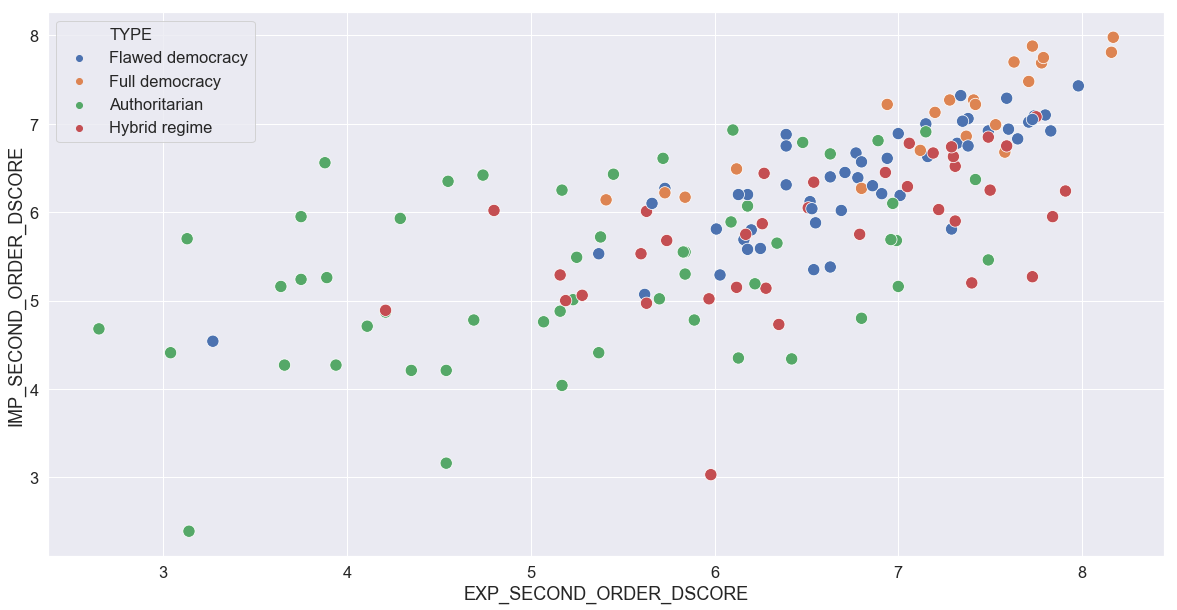

In [64]:
sns.set(font_scale=1.5)
plt.figure(figsize=(20,10))
sct_plt = sns.scatterplot(x='EXP_SECOND_ORDER_DSCORE', y='IMP_SECOND_ORDER_DSCORE', hue='TYPE', data=res, s=150)
fig = sct_plt.get_figure()
fig.savefig("imp_vs_exp.png")

### Find all cases where some country's imports are equal to or more than 10 % of an authoritarian regimes exports...

In [419]:
df_t = g.run("""MATCH (a: Country {regime_type: 'Authoritarian'})-[e:exports_to]->(d:Country) 
//WHERE e.export_value_pct>=10 
RETURN a.name AS AUTHORITARIAN
, e.export_value_pct AS EXP_PCT
, d.name as COUNTERPART
, d.democracy_score as SCORE 
, d.regime_type as REGIME_TYPE 
ORDER BY AUTHORITARIAN, SCORE DESC""").to_data_frame()

### Pick out only the cases where there is at least one flawed/full democracy in list of importers

In [420]:
df_t = pd.crosstab(index=df_t['AUTHORITARIAN'], 
                   columns=df_t['REGIME_TYPE'], 
                   values=df_t['EXP_PCT'], 
                   aggfunc='sum').dropna(how='all', subset = ['Full democracy','Flawed democracy']).fillna(0)

In [421]:
df_t = df_t[df_t['Flawed democracy']+df_t['Full democracy']>df_t['Authoritarian']]

In [422]:
df_t.reset_index()

REGIME_TYPE,AUTHORITARIAN,Authoritarian,Flawed democracy,Full democracy,Hybrid regime,Unknown
0,Afghanistan,15.77,38.82,2.70,42.64,0.02
1,Azerbaijan,5.67,60.34,19.32,13.70,0.93
2,Burma,27.55,52.46,17.21,1.58,1.14
3,Cambodia,9.65,45.10,41.31,0.79,3.16
4,Cameroon,33.70,29.34,28.23,2.22,6.48
5,Chad,14.66,59.28,24.13,1.91,0.01
6,China,11.42,64.55,18.32,4.73,0.96
7,Comoros,8.08,51.63,31.35,8.95,0.01
8,Cuba,40.55,23.11,30.57,2.52,3.22
9,Egypt,27.78,34.68,20.18,15.83,1.48


### Here we calculate the Louvain modularity using the Graph Algorithms module

In [70]:
g.run("""CALL algo.louvain.stream('Country', 'exports_to', {
 graph: 'huge',
 direction: 'BOTH',
 weightProperty: 'export_value_pct',
 levels:4
 ,includeIntermediateCommunities: TRUE
}) YIELD nodeId, community, communities
RETURN algo.asNode(nodeId).name as Country
, algo.asNode(nodeId).democracy_score as SCORE
, algo.asNode(nodeId).regime_type as TYPE
, community
, communities
ORDER BY Country ASC""").to_data_frame().sort_values('community')

,Country,SCORE,TYPE,communities,community
0,Afghanistan,2.85,Authoritarian,"[1, 0, 0]",0
129,Montenegro,5.65,Hybrid regime,"[0, 0, 0]",0
127,Moldova,5.75,Hybrid regime,"[11, 0, 0]",0
123,Mauritania,3.92,Authoritarian,"[26, 1, 0]",0
122,Marshall Islands,NaN,Unknown,"[15, 0, 0]",0
121,Malta,7.95,Flawed democracy,"[15, 0, 0]",0
114,Lithuania,7.50,Flawed democracy,"[6, 0, 0]",0
113,Libya,2.02,Authoritarian,"[15, 0, 0]",0
108,Kyrgyzstan,4.89,Hybrid regime,"[1, 0, 0]",0
104,Kazakhstan,2.94,Authoritarian,"[1, 0, 0]",0


In [54]:
df_com = g.run("""CALL algo.louvain.stream('MATCH (n:Country) WHERE n.democracy_score>0 RETURN id(n) AS id',
 "MATCH (n)-[r:exports_to]->(m:Country) RETURN id(n) AS source
 , n.name as NAME
 , id(m) AS target
 , r.export_value_pct AS weight"
 //, n.democracy_score AS weight"
 ,{
 graph: 'cypher',
 includeIntermediateCommunities: TRUE,
// writeProperty: 'community',
 levels: 4
}) YIELD nodeId, community, communities
RETURN algo.asNode(nodeId).name AS COUNTRY, 
algo.asNode(nodeId).democracy_score as SCORE,
algo.asNode(nodeId).regime_type as TYPE,
algo.asNode(nodeId).EXP_SECOND_ORDER_DSCORE as EXP_SECOND_ORDER_DSCORE, 
algo.asNode(nodeId).IMP_SECOND_ORDER_DSCORE as IMP_SECOND_ORDER_DSCORE,
community AS COMMUNITY, communities AS COMMUNITIES""").to_data_frame()

In [55]:
df_com['COMMUNITIES'].apply(pd.Series)[0].value_counts()

1    70
2    36
3    22
4    19
0     9
5     3
6     2
Name: 0, dtype: int64

In [56]:
df_com['COMMUNITY'].value_counts()

1    91
2    39
0    31
Name: COMMUNITY, dtype: int64

In [57]:
df_com.head(10)

,COMMUNITIES,COMMUNITY,COUNTRY,EXP_SECOND_ORDER_DSCORE,IMP_SECOND_ORDER_DSCORE,SCORE,TYPE
0,"[0, 0]",0,Slovenia,7.38,7.06,7.50,Flawed democracy
1,"[1, 1]",1,United Kingdom,7.41,7.27,8.52,Full democracy
2,"[1, 1]",1,Hungary,7.59,7.29,6.63,Flawed democracy
3,"[1, 1]",1,France,7.28,7.27,8.12,Full democracy
4,"[1, 1]",1,Slovakia,7.60,6.94,7.17,Flawed democracy
5,"[1, 1]",1,Ireland,7.73,7.88,9.24,Full democracy
6,"[1, 1]",1,Italy,7.32,6.78,7.52,Flawed democracy
7,"[2, 2]",2,Israel,6.91,6.21,7.86,Flawed democracy
8,"[1, 1]",1,Netherlands,7.58,6.68,9.01,Full democracy
9,"[2, 2]",2,Mexico,7.80,7.10,6.09,Flawed democracy


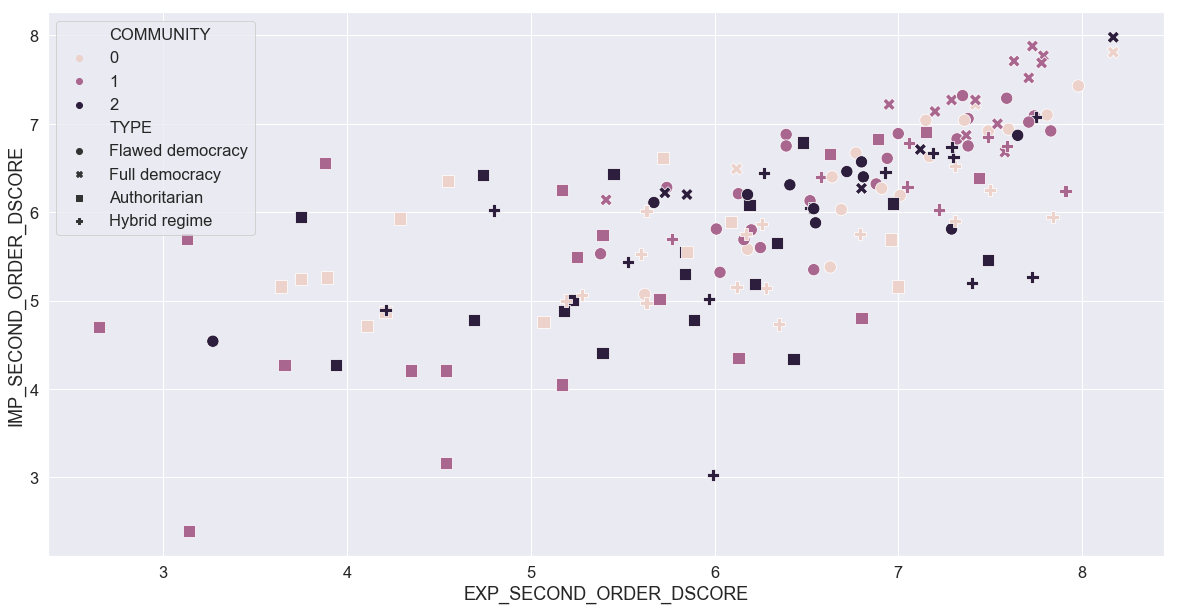

In [347]:
sns.set(font_scale=1.5)
plt.figure(figsize=(20,10))
sct_plt = sns.scatterplot(x='EXP_SECOND_ORDER_DSCORE', 
                          y='IMP_SECOND_ORDER_DSCORE', 
                          hue='COMMUNITY', style='TYPE', data=df_com, s=150)


In [328]:
df_com.loc[df_com['COMMUNITY']==1, 'COUNTRY']

8               United States
9                     Finland
11                   Slovenia
18                     Israel
19                Netherlands
20                     Mexico
23                    Estonia
27                   Thailand
28                    Romania
30                  Lithuania
31                  Hong Kong
34                    Belarus
37                     Serbia
41     Bosnia and Herzegovina
45                Philippines
48                New Zealand
52                 Costa Rica
54       United Arab Emirates
55                   Colombia
56                  Argentina
57                    Uruguay
59        Trinidad and Tobago
60                     Panama
61                      Qatar
62                    Georgia
64                 Kyrgyzstan
65                     Jordan
66                       Iran
68                 Kazakhstan
69            North Macedonia
                ...          
75         Dominican Republic
76                    Moldova
77        

### In the following we calculate a number of different similarity scores. The similarity methods in Neo4j are constructed to compare nodes based on their relation to other nodes. However, I just want to compare based on the numeric properties of each node. That is why the code below looks a bit clunky - I had to fiddle to get it to fit my idea. The perhaps smarter and more graphy way to do it would be to take those numerical values and make them into connection weights to, e.g., a democracy_score node... Also, while it does work based on how I have done it below, I am sure there is an easier way to do it, using some Cypher magic. Unfortunately, I am still at the level of a first year Hogwarts student...

In [ ]:
sim_methods = ['euclidean', 'cosine', 'jaccard', 'pearson', ]

In [29]:
sim_df = g.run("""MATCH (c:Country), (d:Country)
WHERE 1=1
AND id(c)<id(d)
RETURN c.name as from, d.name as to, 
algo.similarity.euclidean([
coalesce(c.EXP_SECOND_ORDER_DSCORE, algo.NaN())
, coalesce(c.IMP_SECOND_ORDER_DSCORE, algo.NaN())
//, coalesce(c.complexity_index, algo.NaN())
, coalesce(c.democracy_score, algo.NaN())
, coalesce(c.environment_perf_index, algo.NaN())
, coalesce(c.social_progress_index, algo.NaN())
, coalesce(c.corruption_index, algo.NaN())
//, coalesce(c.wto_member, algo.NaN())
], 
[coalesce(d.EXP_SECOND_ORDER_DSCORE, algo.NaN())
, coalesce(d.IMP_SECOND_ORDER_DSCORE, algo.NaN())
, coalesce(d.democracy_score, algo.NaN())
, coalesce(d.environment_perf_index, algo.NaN())
, coalesce(d.social_progress_index, algo.NaN())
, coalesce(d.corruption_index, algo.NaN())
//, coalesce(d.wto_member, algo.NaN())
]) AS similarity_euc
, 
algo.similarity.cosine([
coalesce(c.EXP_SECOND_ORDER_DSCORE, algo.NaN())
, coalesce(c.IMP_SECOND_ORDER_DSCORE, algo.NaN())
//, coalesce(c.complexity_index, algo.NaN())
, coalesce(c.democracy_score, algo.NaN())
, coalesce(c.environment_perf_index, algo.NaN())
, coalesce(c.social_progress_index, algo.NaN())
, coalesce(c.corruption_index, algo.NaN())
//, coalesce(c.wto_member, algo.NaN())
], 
[coalesce(d.EXP_SECOND_ORDER_DSCORE, algo.NaN())
, coalesce(d.IMP_SECOND_ORDER_DSCORE, algo.NaN())
, coalesce(d.democracy_score, algo.NaN())
, coalesce(d.environment_perf_index, algo.NaN())
, coalesce(d.social_progress_index, algo.NaN())
, coalesce(d.corruption_index, algo.NaN())
//, coalesce(d.wto_member, algo.NaN())
]) AS similarity_cos
, 
algo.similarity.pearson([
coalesce(c.EXP_SECOND_ORDER_DSCORE, algo.NaN())
, coalesce(c.IMP_SECOND_ORDER_DSCORE, algo.NaN())
//, coalesce(c.complexity_index, algo.NaN())
, coalesce(c.democracy_score, algo.NaN())
, coalesce(c.environment_perf_index, algo.NaN())
, coalesce(c.social_progress_index, algo.NaN())
, coalesce(c.corruption_index, algo.NaN())
//, coalesce(c.wto_member, algo.NaN())
], 
[coalesce(d.EXP_SECOND_ORDER_DSCORE, algo.NaN())
, coalesce(d.IMP_SECOND_ORDER_DSCORE, algo.NaN())
, coalesce(d.democracy_score, algo.NaN())
, coalesce(d.environment_perf_index, algo.NaN())
, coalesce(d.social_progress_index, algo.NaN())
, coalesce(d.corruption_index, algo.NaN())
//, coalesce(d.wto_member, algo.NaN())
]) AS similarity_pearson
ORDER BY from""").to_data_frame()

In [30]:
sim_df

,from,similarity_cos,similarity_euc,similarity_pearson,to
0,Afghanistan,0.984173,0.028619,0.965356,Mongolia
1,Afghanistan,0.996778,0.024731,0.992385,Algeria
2,Afghanistan,0.998390,0.027841,0.996177,Bolivia
3,Afghanistan,NaN,NaN,0.000000,Iraq
4,Afghanistan,0.985515,0.072015,0.965986,Mauritania
5,Afghanistan,0.969404,0.040223,0.925784,Ethiopia
6,Afghanistan,0.998927,0.094041,0.997687,Republic of the Congo
7,Afghanistan,NaN,NaN,0.000000,Libya
8,Afghanistan,0.979227,0.061552,0.950560,Liberia
9,Afghanistan,0.993852,0.062528,0.987147,Mozambique


In [31]:
sim_df = sim_df.dropna(how='any', axis=0).sort_values('from').reset_index(drop=True)

In [32]:
sim_df.sort_values('similarity_pearson', ascending=False)

,from,similarity_cos,similarity_euc,similarity_pearson,to
5823,Netherlands,0.999964,0.186277,0.999980,Norway
8333,Sweden,0.999977,0.450359,0.999969,Finland
1180,Canada,0.999956,0.321848,0.999962,Iceland
7949,Slovenia,0.999964,0.218830,0.999914,Spain
2908,Georgia,0.999449,0.034921,0.999906,Benin
4661,Latvia,0.999959,0.086557,0.999902,Portugal
2145,Denmark,0.999946,0.289853,0.999897,Switzerland
3766,Ireland,0.999896,0.113451,0.999892,United States
9112,United Kingdom,0.999950,0.295707,0.999891,Austria
2309,Dominican Republic,0.999831,0.384297,0.999881,Paraguay


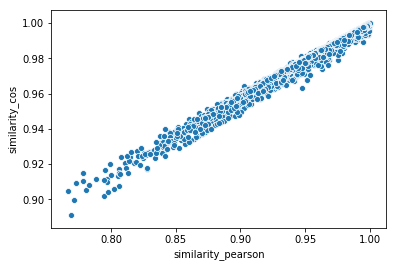

In [33]:
sns.scatterplot(x='similarity_pearson', y='similarity_cos', data=sim_df)